In [4]:
import h5py
import numpy as np
from skimage.util.shape import view_as_windows
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import pandas
import Tracking_Py 

In [5]:
with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/aggregate_1/U_matrix", "r") as file:
    U = file["matrix"][:]

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/aggregate_1/V_matrix", "r") as file:
    V = file["matrix"][:]

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/aggregate_1/M_matrix", "r") as file:
    M = file["matrix"][:]
    
with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/aggregate_1/xgrid_matrix", "r") as file:
    xgrid = file["matrix"][:]
    
with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/aggregate_1/ygrid_matrix", "r") as file:
    ygrid = file["matrix"][:]

# Replace nan in U and V into zeros.
U = np.nan_to_num(U) # (#step, 63, 53) dimensional numpy array.
V = np.nan_to_num(V)

In [6]:
def decode(elem):
    return elem.decode("UTF-8")

with h5py.File("start_points.h5", "r") as file:
    track_id = (list(map(decode, file["track_id"][:])))
    start_x_cor = file["start_x"][:] # List of 1 element lists
    start_y_cor = file["start_y"][:] # List of 1 element lists
    start_t = file["t_interval"][:]  # List of 2 element lists

In [1]:
## Showing vector field. 
# plt.quiver(xgrid[300], ygrid[300], U[300], V[300])

# Error Analysis 1

1. Generate all pseudo tracks and do error statistics with all tracks (original)
2. Extract the region where PIV works better.
3. Determine the optimal scaling factor based on the extracted region tracks (such the lengths of pseudo tracks and original tracks are possibly the same).
4. Do the error statitics on extracted error and compare it to the original one without scaling.

## The pseudo tracks and original tracks

In [4]:
# The original pseudo tracks without rescaling.
pseudo_track_x_1, pseudo_track_y_1 = Tracking_Py.pseudo_tracking_piv_grid_v2(U, V, start_t, start_x_cor,
                                                            start_y_cor, (1, 1))
pseudo_t = Tracking_Py.convert_form_piv_time(start_t)

In [5]:
# Load original tracks
track_csv = pandas.read_csv("F:/PhD_Franziska/Headon/Headon_results/v1_slice3(incl.tracking)/video1_tracking_cleaned.csv")
original_x_track, original_y_track, original_t_track = Tracking_Py.original_track(track_id, track_csv)

In [6]:
# Error statistics between original psedo tracks and originall tracks. 
error_in_time, mean_error_in_time = Tracking_Py.error_time_step(track_id, original_x_track, original_y_track,
                                                               pseudo_track_x_1, pseudo_track_y_1)

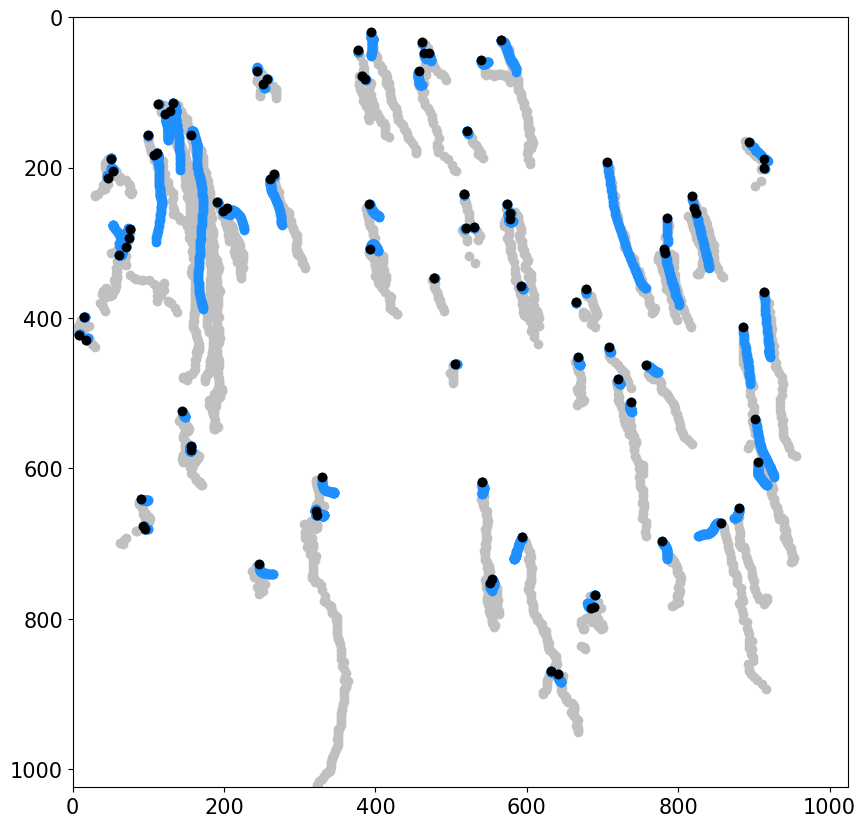

In [7]:
# Plot the pseudo track and original tracks
o_index_list = [i for i in range(len(original_x_track))]
Tracking_Py.plot_original_pseudo_overlap(o_index_list, original_x_track, original_y_track, original_t_track,
                            pseudo_track_x_1, pseudo_track_y_1, pseudo_t, start_x_cor, start_y_cor, 
                            "overlap_origi_piv")

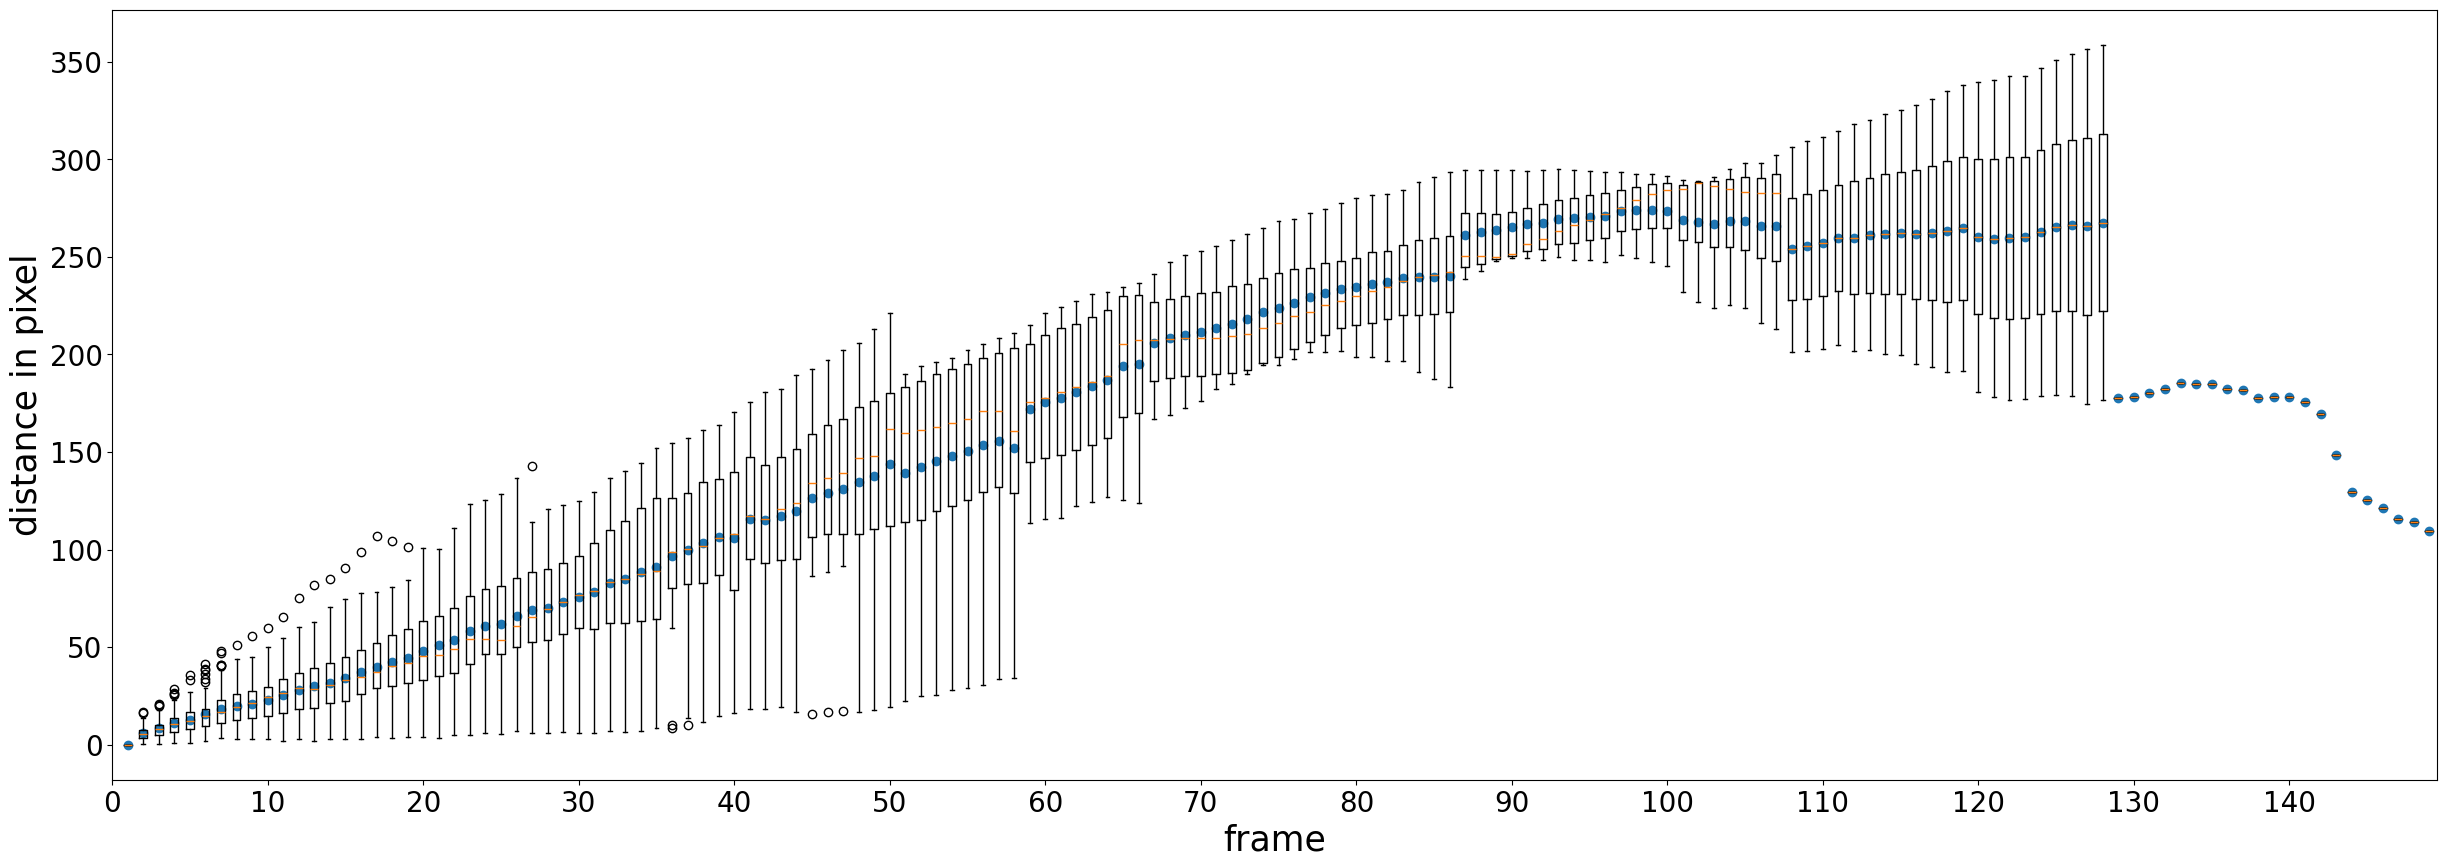

In [8]:
# Plot the error in pixel.
Tracking_Py.plot_time_error(track_id, original_x_track, original_y_track, pseudo_track_x_1, pseudo_track_y_1,
                "time_error_all_tracks(no_scaling)")

## Extract well performed subregions and determine the optimal scaling factor based on tracks in the subregion.

In [9]:
factor, _, index_list = Tracking_Py.optimal_scale_factor(track_id, start_x_cor, start_y_cor, original_x_track, 
                        original_y_track, pseudo_track_x_1, pseudo_track_y_1)

# calculate the pseudo tracks with optimal scaling factor.
opti_pseudo_x, opti_pseudo_y = Tracking_Py.pseudo_tracking_piv_grid_v2(U, V, start_t, start_x_cor,
                                                            start_y_cor, (factor, factor))

# The subset of original tracks and pseudo tracks with optimal factor.
sub_origi_id, sub_origi_x, sub_origi_y, sub_origi_t, sub_origi_start_x, sub_origi_start_y = Tracking_Py.select_by_index(track_id,
                                                                                            index_list, 
                                                                                            original_x_track, 
                                                                                            original_y_track,
                                                                                            original_t_track, 
                                                                                            start_x_cor, start_y_cor)
sub_piv_id, sub_piv_x, sub_piv_y, sub_piv_t, sub_piv_start_x, sub_piv_start_y = Tracking_Py.select_by_index(track_id, index_list, 
                                                                                opti_pseudo_x, opti_pseudo_y, 
                                                                                start_t, start_x_cor, start_y_cor)

sub_piv_t_v2 = Tracking_Py.convert_form_piv_time(sub_piv_t)
pseudo_t_v2 = Tracking_Py.convert_form_piv_time(start_t)

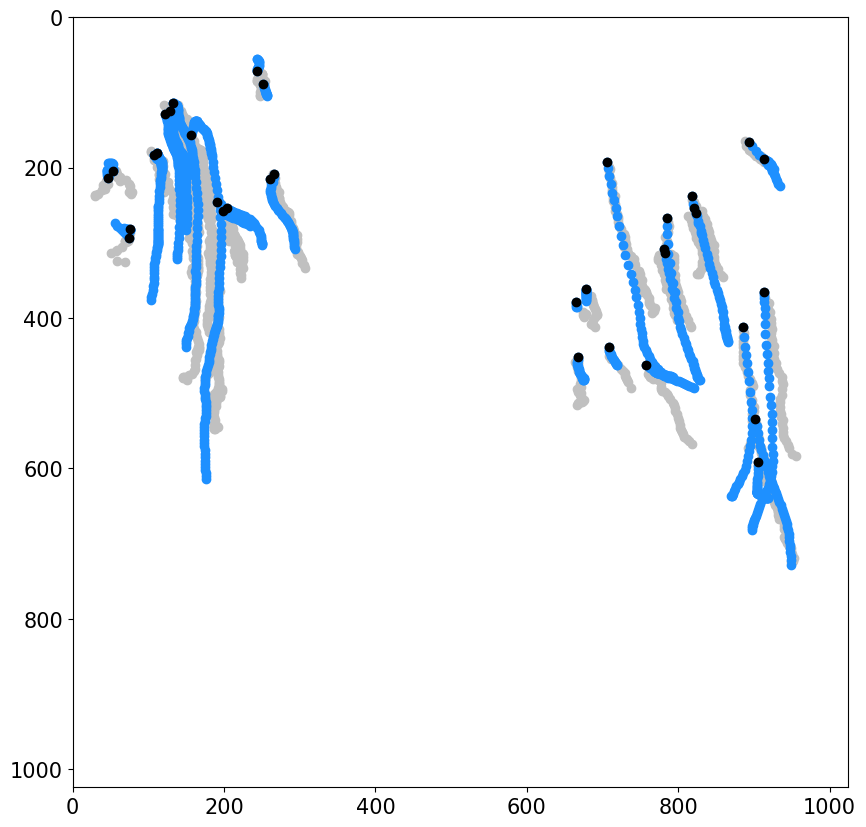

In [10]:
Tracking_Py.plot_original_pseudo_overlap(index_list, sub_origi_x, sub_origi_y, sub_origi_t,
                            sub_piv_x, sub_piv_y, sub_piv_t_v2, sub_piv_start_x, sub_piv_start_y,
                             "overlap_origi_piv_opti_factor_subregion")

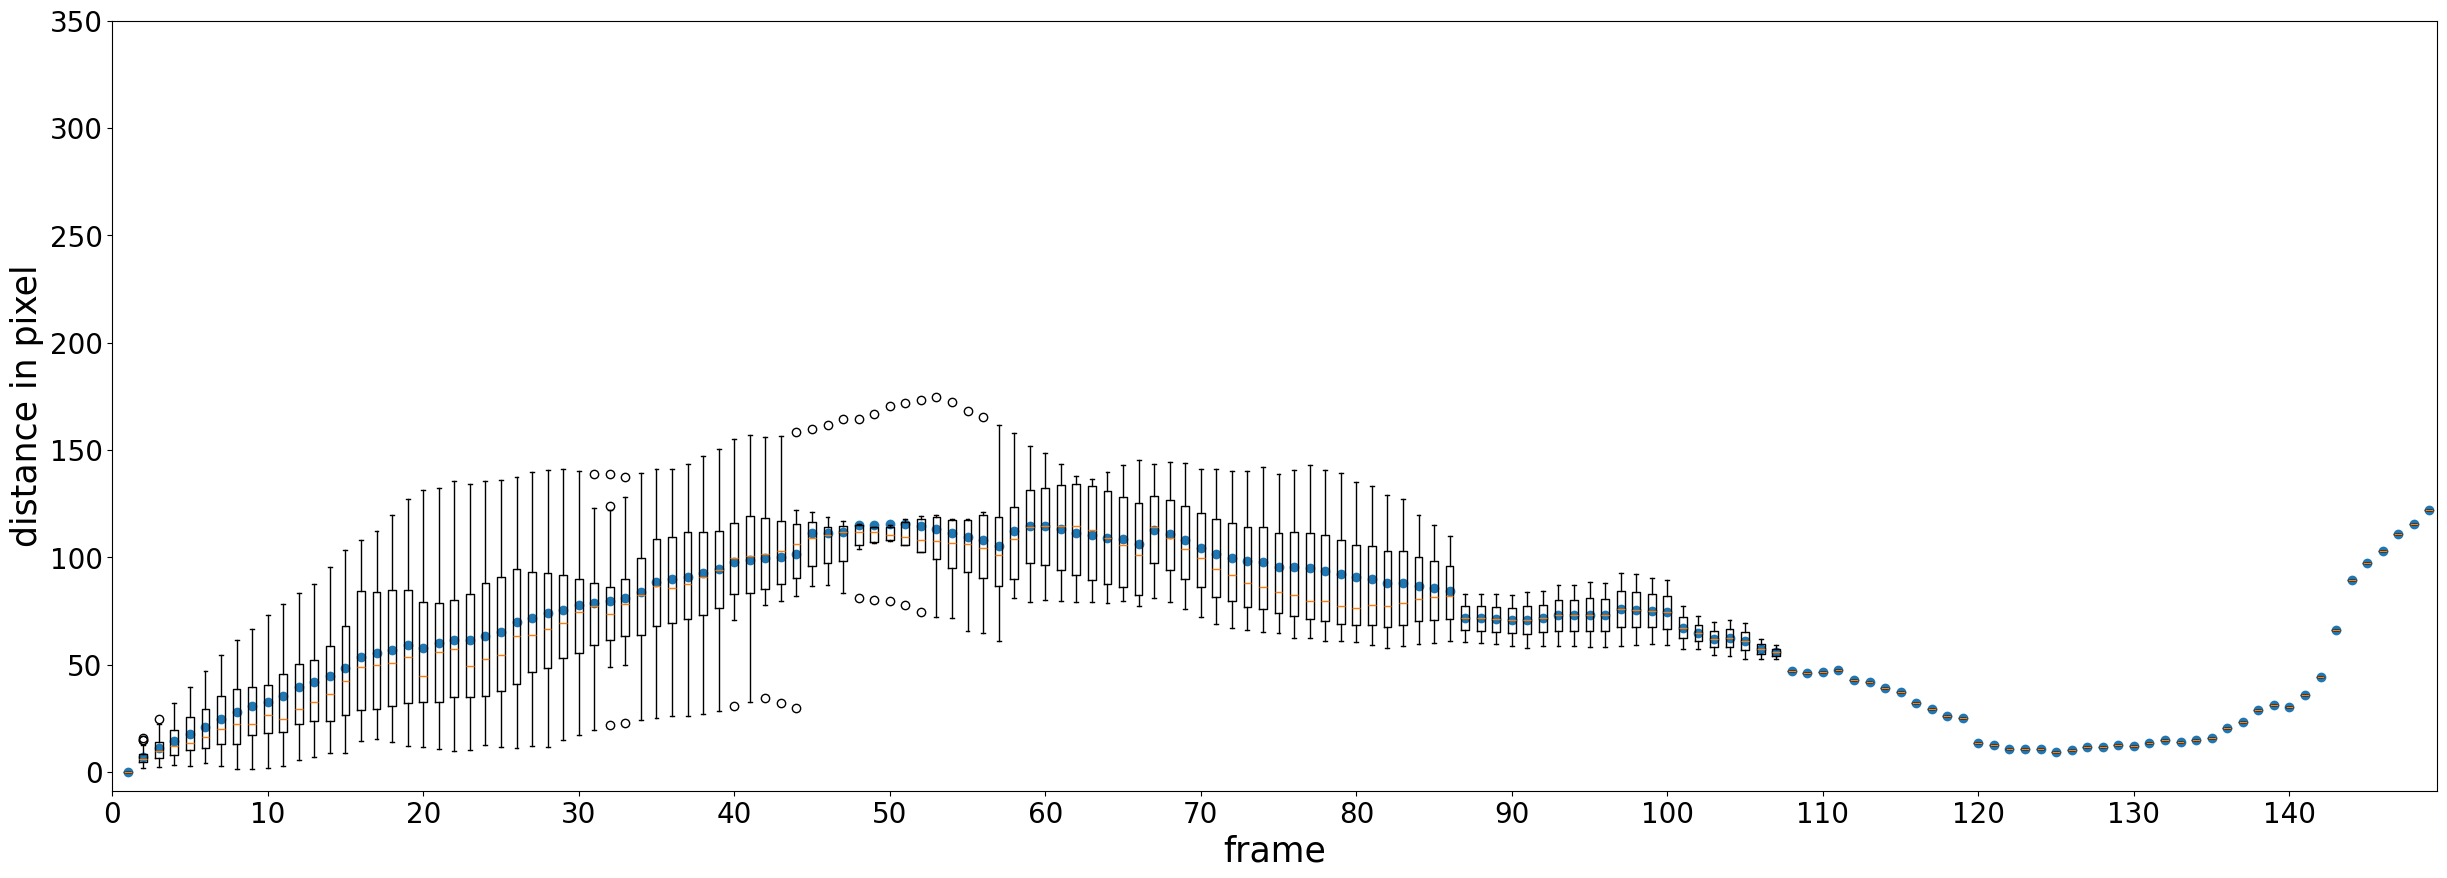

In [11]:
Tracking_Py.plot_time_error(sub_origi_id, sub_origi_x, sub_origi_y, sub_piv_x, sub_piv_y,
                "time_error_periderm_tracks")

## Apply the optimal scaling factor on all tracks and look at the error statistics.

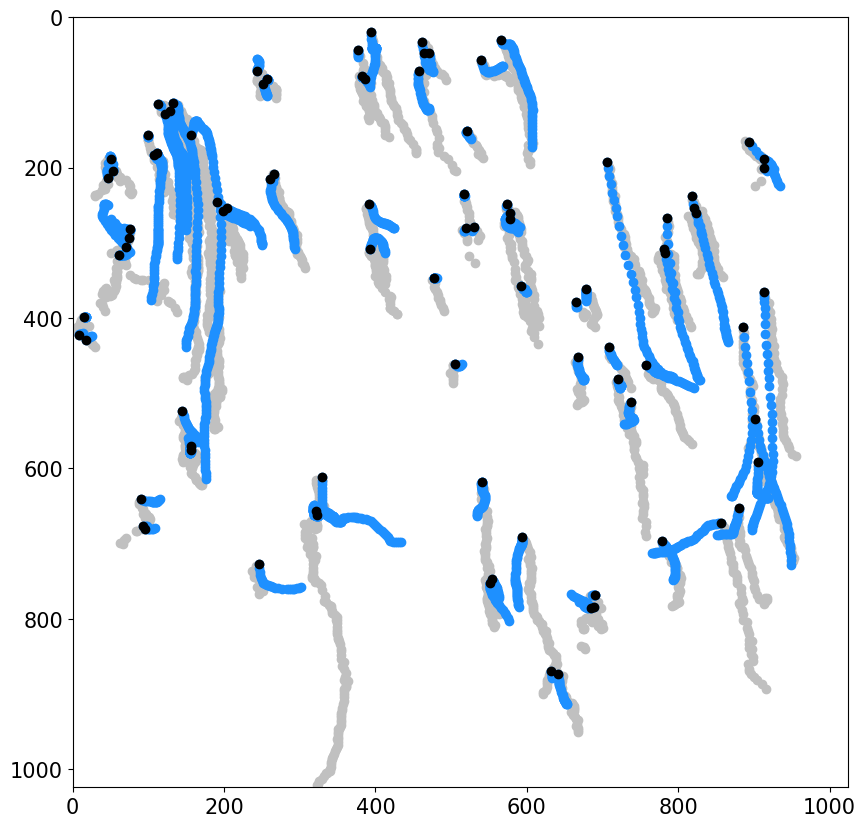

In [12]:
o_index_list = [i for i in range(len(original_x_track))]
Tracking_Py.plot_original_pseudo_overlap(o_index_list, original_x_track, original_y_track, original_t_track,
                            opti_pseudo_x, opti_pseudo_y, pseudo_t_v2, start_x_cor, start_y_cor, 
                            "overlap_origi_piv_opti_factor")

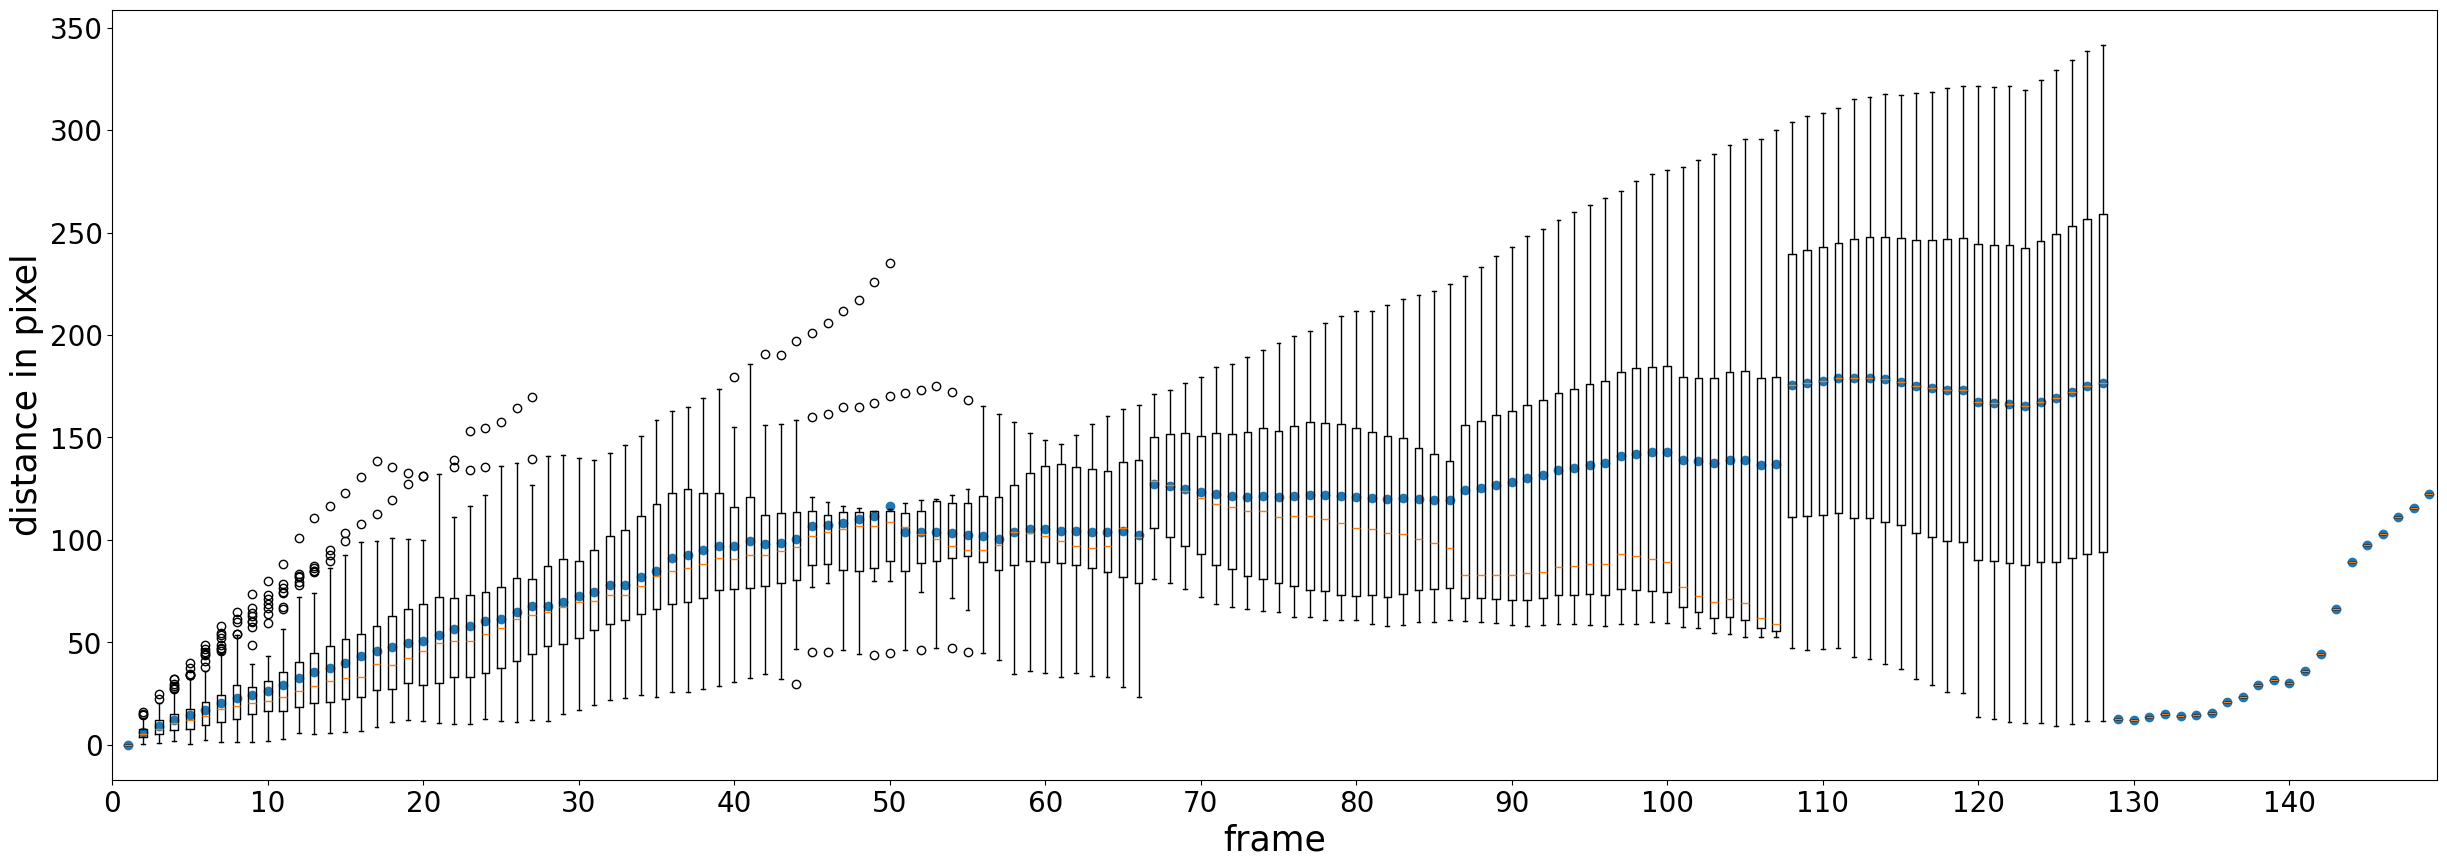

In [13]:
Tracking_Py.plot_time_error(track_id, original_x_track, original_y_track, opti_pseudo_x, opti_pseudo_y,
                "time_error_all_tracks")

# Error Analysis 2

Normalize the error distance in pixel through single track lengths. Hereby still applying the optimal scaling factor from above (generated from extracted regions). 
1. generate the error in distance in each frame (for all tracks and subregion). Determine the single track lengths.
2. At each frame devide the error by corresponding track length. 

In [2]:
# # The same function also in the module Tracking_Py ! However cannot be imported here?!
# def rescale_track_error_by_origi_track_len(track_id, original_x, original_y, piv_x, piv_y): 
#     # Rescale for each track the track error by corresponding length of the track.
#     # len(factor_list) = len(track_id)

#     # Get the track error. 
#     all_track_error = Tracking_Py.track_error(track_id, original_x, original_y, piv_x, piv_y)

#     # All original track lengths.
#     origi_track_length = Tracking_Py.track_length(original_x_track, original_y_track)

#     # Rescale the track error by the corresponding track length.
#     rescaled_track_error = []
#     for i in range(len(track_id)): 
#         rescaled_track_error.append(all_track_error[i]/origi_track_length[i])

#     return rescaled_track_error

In [3]:
# Tracking_Py.rescale_track_error_by_origi_track_len(track_id, original_x_track, original_y_track, opti_pseudo_x, opti_pseudo_y)

In [4]:
# # Modify the same function from Tracking_Py only change the all_track_error generating function.

# def error_time_step(track_id, original_x, original_y, piv_x, piv_y):
#     # Generate firstly all track errors/difference.
#     all_track_error = rescale_track_error_by_origi_track_len(track_id, original_x_track, 
#                                                               original_y_track, piv_x, piv_y)

#     # Get the elements columnwise and fill the non-exist time steps with nan.  
#     # Fill all track step witdth with nan to the maximal length. 
#     max_len = max(len(l) for l in all_track_error)
#     # Correct the length of original tracking data, since some points are skipped. 
#     for i in range(len(track_id)): 
#         error = all_track_error[i]
#         num_nan = max_len - len(error)
#         all_track_error[i] = np.concatenate([error, np.full(num_nan, np.nan)])
        
#     all_track_error = np.array(all_track_error)
#     # Each coloum are errors in the same time step.
#     time_error = []
#     mean_time_error = []

#     for j in range(max_len):
#         error = all_track_error[:, j] # Extract the colums --> all errors at the same time step.
#         error_clean = error[~np.isnan(error)] # Get rid of the nan in coloums.
#         time_error.append(error_clean)
#         mean_time_error.append(np.mean(error_clean))

#     return time_error, mean_time_error #, all_track_error # TODO: outcomment the all_track_error! 

In [5]:
# # Modification of the same attribute in module Tracking_Py.py
# def plot_time_error(track_id, original_x_track, original_y_track, piv_x_track, piv_y_track,
#                    fig_name): # Generate the box plot of distance between original tracks and pseudo tracks vs.frame.
    
#     # Generate the data of distance between pseudo tracks and original tracks in dependence of frame.
#     time_error, mean_time_error = error_time_step(track_id, original_x_track, 
#                                                 original_y_track, piv_x_track, piv_y_track)
    
#     positions = [i for i in range(1, len(mean_time_error)+1)]
#     # Plot
#     plt.style.use('default')
#     plt.figure(figsize=(30, 10))
#     plt.boxplot(time_error)
#     plt.scatter(positions, mean_time_error)
#     plt.xticks(np.arange(0, len(mean_time_error), step=10), np.arange(0, len(mean_time_error), step=10), fontsize=20)
#     plt.yticks([0, 1, 2], [0, 1, 2],fontsize=20)
#     plt.xlabel("frame", fontsize=25)
#     plt.ylabel("error distance relative to track length", fontsize=25)
#     plt.savefig(fig_name, dpi=300) # fig_name a string.
#     plt.show()

In [6]:
# # Error between all pseudo tracks (no scaling) and all original tracks. 
# plot_time_error(track_id, original_x_track, original_y_track, pseudo_track_x_1, pseudo_track_y_1,
#                 "track_error_rescaled_by_track_length(no_scale)")

In [7]:
# # Error between all pseudo tracks (with optimal scaling factor) and all original tracks.
# plot_time_error(track_id, original_x_track, original_y_track, opti_pseudo_x, opti_pseudo_y,
#                 "track_error_rescaled_by_track_length(optimal_scale)")

In [8]:
# # Error between tracks (optimal scaling) and original tracks from selected region.

# # rescale_track_error_by_origi_track_len(sub_origi_id, sub_origi_x, sub_origi_y, sub_piv_x, sub_piv_y)
# error_time_step(sub_origi_id, sub_origi_x, sub_origi_y, sub_piv_x, sub_piv_y)
# # plot_time_error(sub_origi_id, sub_origi_x, sub_origi_y, sub_piv_x, sub_piv_y,
# #                 "track_error_rescaled_by_track_length(optimal_scale+sub_region)")

In [9]:
# for i in range(len(sub_origi_id)): 
#     Tracking_Py.track_dist(sub_origi_x[i], sub_origi_y[i], sub_piv_x[i], sub_piv_y[i])
#     print(i)